In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from hawkes import hawkes, hawkes_calculate, sampleHawkes, plotHawkes, iterative_sampling, extract_samples, sample_counterfactual_superposition, check_monotonicity_hawkes
sys.path.append(os.path.abspath('../'))
from sampling_utils import thinning_T, return_samples
from counterfactual_tpp import sample_counterfactual, check_monotonicity

# Sampling From Lambda_max

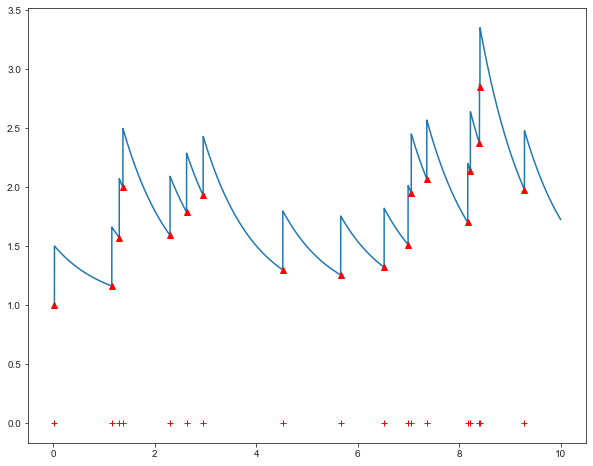

In [2]:
# required parameters
mu0 = 1
alpha = 0.5
w = 1
lambda_max = 4
T = 10
maxNev = 50
def constant1(x): return mu0
# sampling from hawkes using the superposition property
initial_sample, indicators = thinning_T(0, constant1, lambda_max, maxNev, T)
events = {initial_sample[i]: indicators[i] for i in range(len(initial_sample))}
all_events = {}
all_events[mu0] = events
iterative_sampling(all_events, events, mu0, alpha, w, lambda_max, maxNev, T)
# plotting hawkes
sampled_events = list(all_events.keys())[1:]
sampled_events.sort()
sampled_events = np.array(sampled_events)
sampled_lambdas = hawkes(sampled_events, mu0, alpha, w)
plt.figure(figsize=(10, 8))
tvec, l_t = plotHawkes(sampled_events, mu0, alpha, w, T, 10000.0, label= 'intensity')
plt.plot(sampled_events, sampled_lambdas, 'r^')
plt.show() 

In [3]:
# extract all sampled events from all_events dictionary.
all_samples, all_lambdas = extract_samples(all_events, sampled_events, mu0, alpha, w)

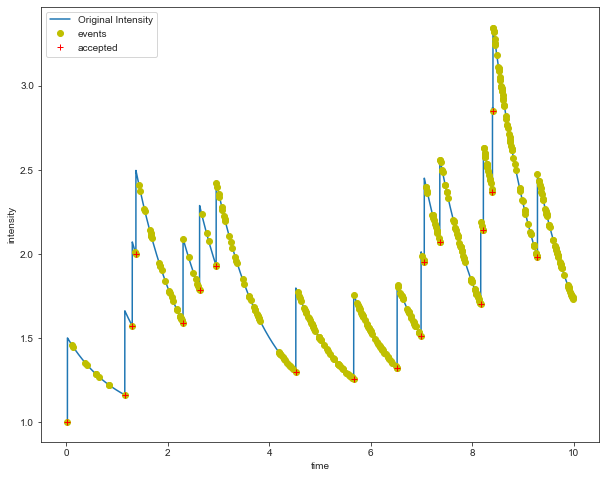

In [4]:
# plots all events, both accepted and rejected with their intensities.
plt.figure(figsize=(10, 8))
plt.plot(tvec, l_t, label = 'Original Intensity')
plt.plot(all_samples, all_lambdas, 'oy', label = 'events')
plt.plot(sampled_events,sampled_lambdas, 'r+', label = 'accepted')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()

In [5]:
# sampling from the counterfactual intensity.
new_mu0 = 2
new_alpha = 0.1
real_counterfactuals = sample_counterfactual_superposition(mu0, alpha, new_mu0, new_alpha, all_events, lambda_max, maxNev, w, T)

**The red +s are the counterfactuals.**

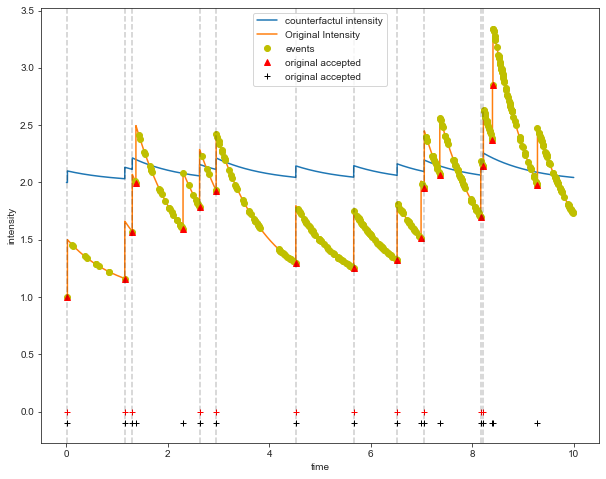

In [6]:
plt.figure(figsize=(10, 8))
plotHawkes(np.array(real_counterfactuals), new_mu0, new_alpha, w, T, 10000.0, label= 'counterfactul intensity')
plt.plot(tvec, l_t, label = 'Original Intensity')
plt.plot(all_samples, all_lambdas, 'oy', label = 'events')
plt.plot(sampled_events,sampled_lambdas, 'r^', label = 'original accepted')
plt.plot(sampled_events,np.full(len(sampled_events), -0.1), 'k+', label = 'original accepted')
for xc in real_counterfactuals:
    plt.axvline(x=xc, color = 'k', ls = '--', alpha = 0.2)
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend() 

In the following cell, we will check monotonicity property. Note that this property should hold in **each exponential created by superposition** (please have a look at `check_monotonicity_hawkes` in `hawkes.py` for more details.). 

In [7]:
check_monotonicity_hawkes(mu0, alpha, new_mu0, new_alpha, all_events, sampled_events, real_counterfactuals, w)

MONOTONIC


# Real-World Scenario

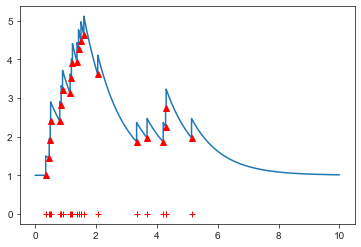

In [8]:
# First, we sample from the hawkes process using the Ogata's algorithm (or any other sampling method), but only store the accepted events.
mu0 = 1
alpha = 0.5
w = 1
lambda_max = 5
T = 10
maxNev = 25
tev, tend, lambdas_original = sampleHawkes(mu0, alpha, w, T, maxNev)
tvec, l_t = plotHawkes(tev, mu0, alpha, w, T, 10000.0, label = 'Original Intensity')
plt.plot(tev, lambdas_original, 'r^', label = 'samples')


In [9]:
# this list stores functions corresponding to each exponential.
exponentials = []
all_events = {}
exponentials.append(lambda t: mu0)
all_events[mu0] = {}
for i in range(len(tev)):
    exponentials.append(lambda t: alpha * np.exp(-w * (t - tev[i])))
    all_events[tev[i]] = {}

# we should assign each accepted event to some exponential. (IMPORTANT)
for i in range(len(tev)):
    if i == 0:
        all_events[mu0][tev[i]] = True
    else:
        probabilities = [exponentials[j](tev[i]) for j in range(0, i + 1)]
        probabilities = [float(i)/sum(probabilities) for i in probabilities]
        a = np.random.choice(i + 1, 1, p = probabilities)
        if a == 0:
            all_events[mu0][tev[i]] = True
        else:
            all_events[tev[a[0] - 1]][tev[i]] = True

In [10]:
# using the superposition to calculate the difference between lambda_max and the exponentials, and sample from it.
differences = []
differences.append(lambda t: lambda_max - mu0)
for k in range(len(tev)):
    f = lambda t: lambda_max - alpha * np.exp(-w * (t - tev[k]))
    differences.append(f)

for i in range(len(differences)):
    if i == 0:
        rejceted, indicators = thinning_T(0, differences[i], lambda_max, maxNev, T)
    else:
        rejceted, indicators = thinning_T(tev[i - 1], differences[i], lambda_max, maxNev, T)
    
    rejceted = {rejceted[j]: False for j in range(len(rejceted)) if indicators[j] == True}
    if i == 0:
        all_events[mu0].update(rejceted)
        all_events[mu0] = {k:v for k,v in sorted(all_events[mu0].items())}
    else:
        all_events[tev[i - 1]].update(rejceted)
        all_events[tev[i - 1]] = {k:v for k,v in sorted(all_events[tev[i - 1]].items())}


In [11]:
all_samples, all_lambdas = extract_samples(all_events, tev, mu0, alpha, w)

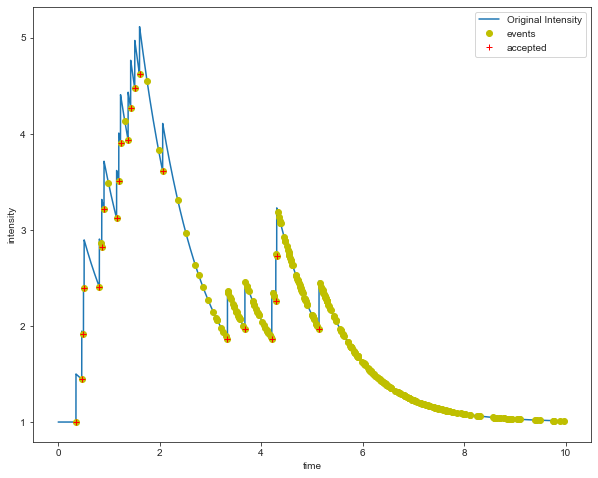

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(tvec, l_t, label = 'Original Intensity')
plt.plot(all_samples, all_lambdas, 'oy', label = 'events')
plt.plot(tev,lambdas_original, 'r+', label = 'accepted')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()

In [13]:
new_mu0 = 2.8
new_alpha = 0.5
real_counterfactuals = sample_counterfactual_superposition(mu0, alpha, new_mu0, new_alpha, all_events, lambda_max, maxNev, w, T)

In [14]:
print(len(tev))
print(len(real_counterfactuals))

21
22


**The red +s are the counterfactuals.**

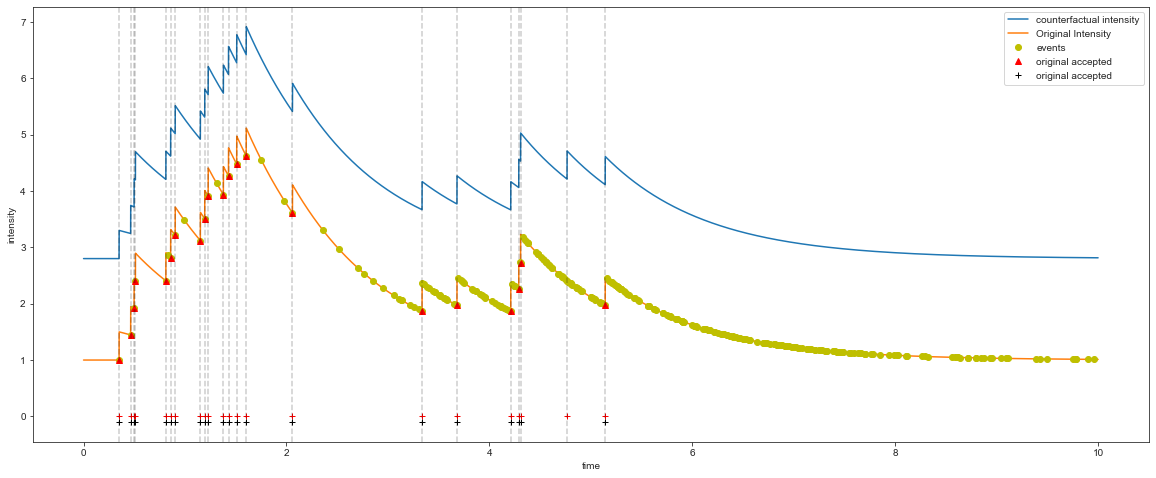

In [18]:
plt.figure(figsize=(20, 8))
plotHawkes(np.array(real_counterfactuals), new_mu0, new_alpha, w, T, 10000.0, label= 'counterfactual intensity')
plt.plot(tvec, l_t, label = 'Original Intensity')
plt.plot(all_samples, all_lambdas, 'oy', label = 'events')
plt.plot(tev,lambdas_original, 'r^', label = 'original accepted')
plt.plot(tev,np.full(len(tev), -0.1), 'k+', label = 'original accepted')
for xc in real_counterfactuals:
    plt.axvline(x=xc, color = 'k', ls = '--', alpha = 0.2)
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()  

In [16]:
check_monotonicity_hawkes(mu0, alpha, new_mu0, new_alpha, all_events, tev, real_counterfactuals, w)

MONOTONIC
